In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------- Graph ---------------------------------- #
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
from bokeh.transform import factor_cmap

# Pour afficher directement dans le notebook
output_notebook()

# ----------------------------------- Model ---------------------------------- #
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GaussianNoise
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

tf.random.set_seed(42)

Loading BokehJS ...

# Data exploration

In [3]:
technical_df = pd.read_csv("../Data/Nasdaq-100 Technical/NASDAQ_100.csv", sep=",")
technical_df.drop(columns=["avg_vol_20d", "change_percent"], inplace=True)

## Data processing

In [3]:
technical_df["SMA_20"] = technical_df["close"].rolling(window=20).mean()
technical_df["EMA_20"] = technical_df["close"].ewm(span=20, adjust=False).mean()

technical_df["Bollinger_Mid"] = technical_df["close"].rolling(window=20).mean()
technical_df["Bollinger_Std"] = technical_df["close"].rolling(window=20).std()
technical_df["Bollinger_Upper"] = technical_df["Bollinger_Mid"] + (2 *technical_df["Bollinger_Std"])
technical_df["Bollinger_Lower"] = technical_df["Bollinger_Mid"] - (2 *technical_df["Bollinger_Std"])

window_length = 14

# Calcul des variations de prix
delta =technical_df["close"].diff()

# Séparation des gains et des pertes
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Moyenne mobile exponentielle des gains et pertes
avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

# Calcul du RS (Relative Strength)
rs = avg_gain / avg_loss

# Calcul du RSI
technical_df["RSI"] = 100 - (100 / (1 + rs))

In [5]:
technical_df['date'] = pd.to_datetime(technical_df['date'])

# We keep only from 2017 to 2022 because of the Fundamental dataset
technical_filtered_df = technical_df[(technical_df['date'] >= "2017-01-01") & (technical_df['date'] <= "2022-12-31")]

In [ ]:
technical_filtered_df

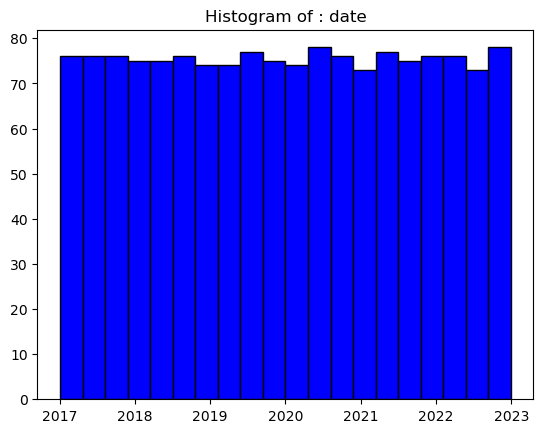

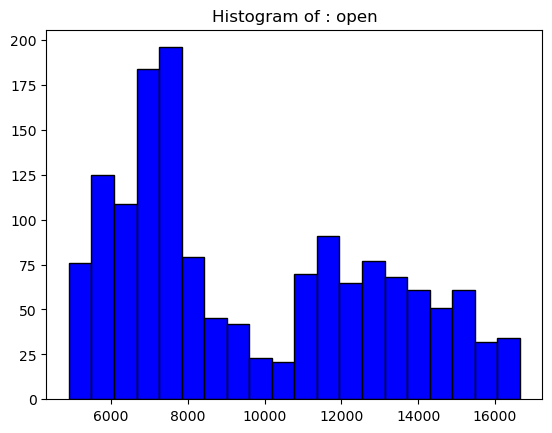

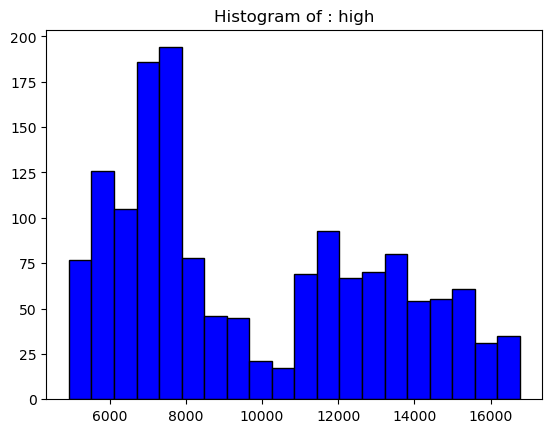

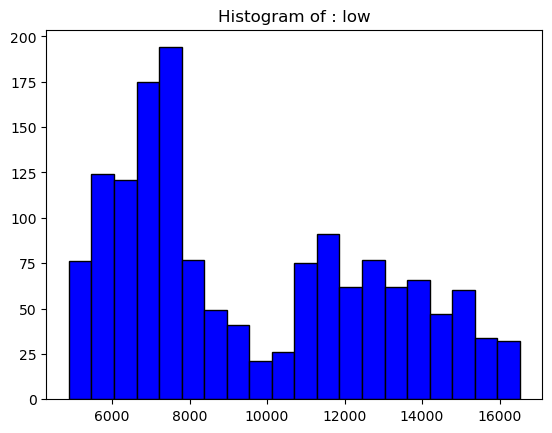

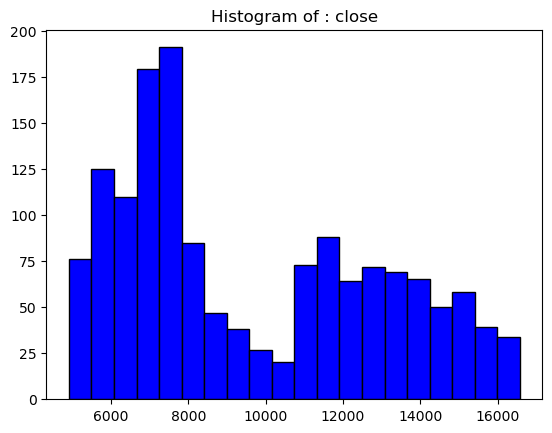

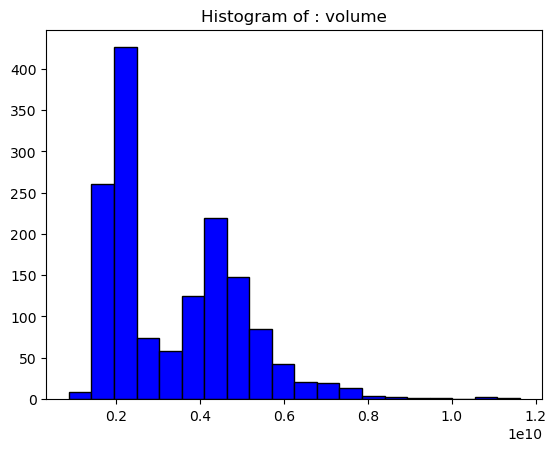

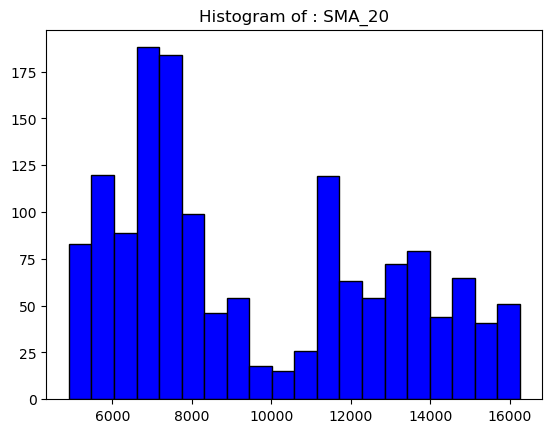

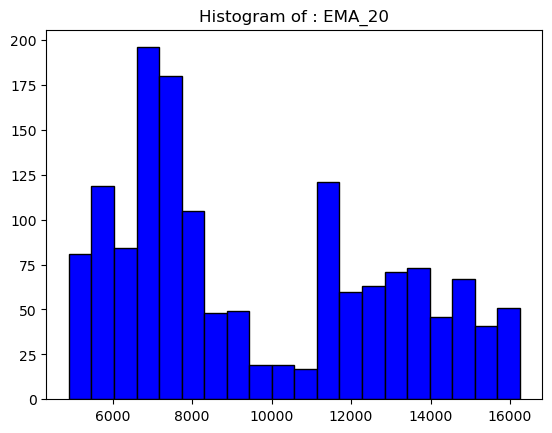

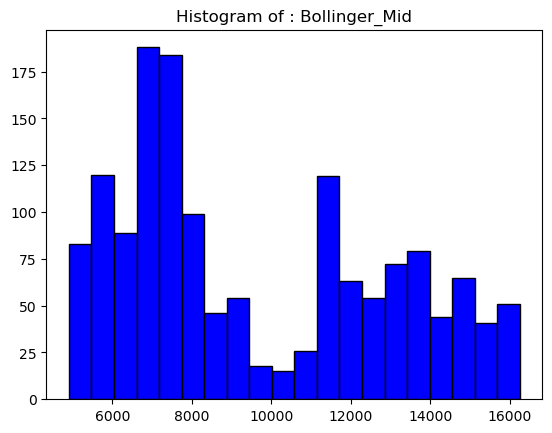

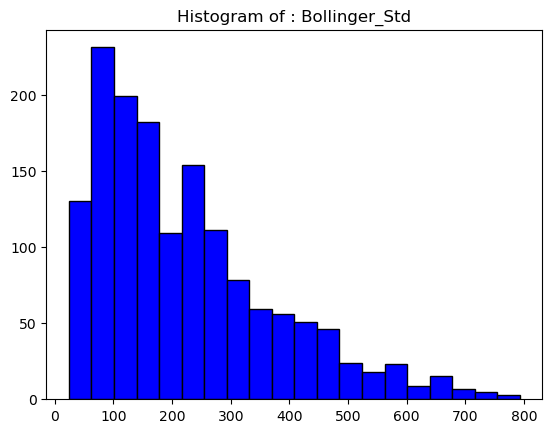

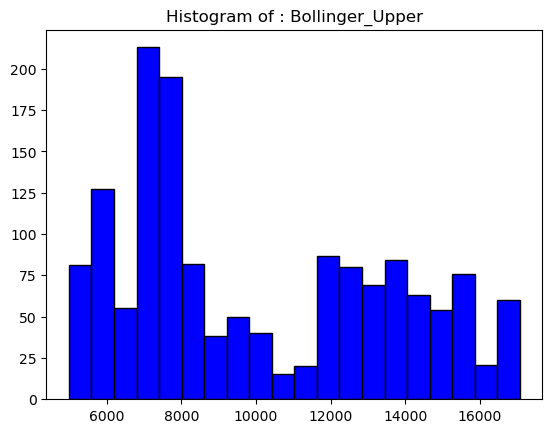

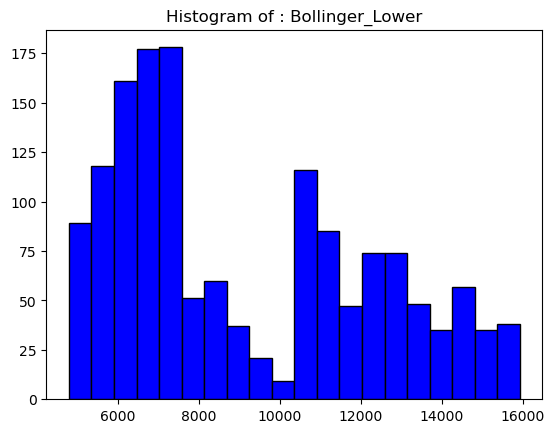

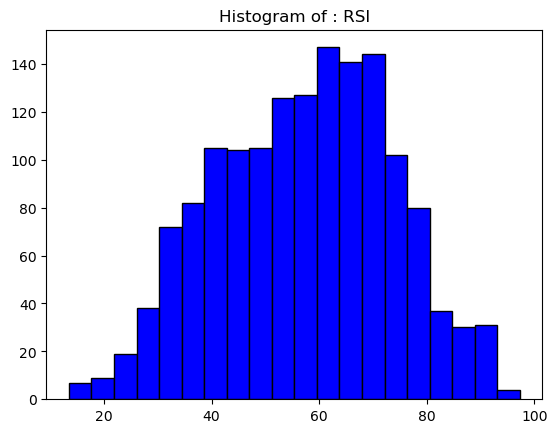

In [373]:
for i in range(technical_filtered_df.shape[1]):
    plt.hist(technical_filtered_df.iloc[:,i], bins=20, color="blue", edgecolor="black")
    plt.title("Histogram of : {}".format(technical_df.columns.tolist()[i]))
    plt.show()

## Plot the stock index

In [6]:
# Convertir les données en ColumnDataSource
source = ColumnDataSource(technical_filtered_df)

# Graphique des prix (line chart)
price_fig = figure(
    x_axis_type="datetime", 
    title="Prix au fil du temps",
    height=400, width=1000
)

price_fig.line('date', 'close', source=source, line_width=2, color='blue', legend_label="Prix de clôture")
price_fig.scatter('date', 'close', source=source, size=8, color='blue', legend_label="Prix de clôture")
price_fig.legend.location = "top_left"
price_fig.xaxis.axis_label = "Date"
price_fig.yaxis.axis_label = "Prix"

# Graphique des volumes (bar chart)
volume_fig = figure(
    x_axis_type="datetime", 
    title="Volume des transactions",
    height=400, width=1000
)
volume_fig.vbar(x='date', top='volume', width=0.8, source=source, color="orange", legend_label="Volume")
volume_fig.legend.location = "top_left"
volume_fig.xaxis.axis_label = "Date"
volume_fig.yaxis.axis_label = "Volume"

# Afficher les graphiques ensemble
layout = column(price_fig, volume_fig)
show(layout)

# LSTM

In [5]:
# --------------------------------- Découpage -------------------------------- #
# Découper en train (70%) et reste (30%)
train_df, temp_df = train_test_split(technical_df.iloc[19:,:].drop(columns="date"), test_size=0.3, random_state=42, shuffle=False)

# Découper le reste en validation (10%) et test (20%)
val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42, shuffle=False)  # 20% de df

# Vérification des tailles
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# ------------------------------- Normalization ------------------------------ #
scaler = MinMaxScaler()

train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)
val_df_scaled = scaler.transform(val_df)

Train size: 6787
Validation size: 970
Test size: 1940


In [6]:
def create_sequences(data, target_index, sequence_length, prediction_steps):
    X = []
    y = []

    # Parcours des données pour créer des séquences
    for i in range(len(data) - sequence_length - prediction_steps):
        # Séquence d'entrée (features)
        seq_X = np.delete(data[i:i + sequence_length], target_index, axis=1)
        # Séquence cible (target uniquement)
        seq_y = data[i + sequence_length:i + sequence_length + prediction_steps, target_index]
        X.append(seq_X)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [7]:
# Paramètres
sequence_length = 60  # Utiliser 60 jours comme entrée
prediction_steps = 3  # Prédire 3 jours
target_index = 3  # Colonne de la target (par exemple, daily_percentage_change)

# Créer les séquences
X_train, y_train = create_sequences(train_df_scaled, target_index, sequence_length, prediction_steps)
X_test, y_test = create_sequences(test_df_scaled, target_index, sequence_length, prediction_steps)
X_val, y_val = create_sequences(val_df_scaled, target_index, sequence_length, prediction_steps)

print("Shape of X :", X_train.shape)  # (num_sequences, sequence_length, num_features)
print("Shape of y :", y_train.shape)  # (num_sequences, prediction_steps)

print("\nShape of X_test :", X_test.shape)
print("Shape of X_val :", X_val.shape)

Shape of X : (6724, 60, 11)
Shape of y : (6724, 3)

Shape of X_test : (1877, 60, 11)
Shape of X_val : (907, 60, 11)


In [20]:
# # Paramètres
# sequence_length = 60  # Utiliser 1 an comme entrée
# prediction_steps = 3  # Prédire 1 an
# target_index = 3  # Colonne de la target (par exemple, daily_percentage_change)
# data = technical_df.iloc[19:,:].drop(columns="date")

# # Exemple : créer les séquences
# X, y = create_sequences(data, target_index, sequence_length, prediction_steps)
# print("Shape de X :", X.shape)  # (num_sequences, sequence_length, num_features)
# print("Shape de y :", y.shape)  # (num_sequences, prediction_steps)

In [387]:
# 1. Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 2. Séparer l'ensemble d'entraînement en train et validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

# ---------------------------------- Scaling --------------------------------- #
# Initialisation du scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Appliquer le scaler sur toutes les features (en gardant la séquence)
X_train_scaled = np.zeros_like(X_train)
for i in range(X_train.shape[2]):  # itérer sur les features
    X_train_scaled[:, :, i] = scaler_X.fit_transform(X_train[:, :, i])

y_train_scaled = scaler_y.fit_transform(y_train)

# Transformation sur X_test et y_test (pas de fit ici)
X_test_scaled = np.zeros_like(X_test)
for i in range(X_test.shape[2]):  # itérer sur les features
    X_test_scaled[:, :, i] = scaler_X.transform(X_test[:, :, i])

y_test_scaled = scaler_y.transform(y_test)

# Transformation sur X_test et y_test (pas de fit ici)
X_val_scaled = np.zeros_like(X_val)
for i in range(X_val.shape[2]):  # itérer sur les features
    X_val_scaled[:, :, i] = scaler_X.transform(X_val[:, :, i])

y_val_scaled = scaler_y.transform(y_val)

# Affichage des formes des ensembles résultants
print(f"Shape de X_train : {X_train_scaled.shape}")
print(f"Shape de X_val : {X_val_scaled.shape}")
print(f"Shape de X_test : {X_test_scaled.shape}")

Shape de X_train : (925, 60, 10)
Shape de X_val : (232, 60, 10)
Shape de X_test : (290, 60, 10)


In [16]:
# Création du modèle
model = Sequential([
    GaussianNoise(0.1, input_shape=(sequence_length, X_train.shape[2])),
    LSTM(128, activation='relu', recurrent_regularizer=tf.keras.regularizers.l2(0.2), return_sequences=True),
    Dropout(0.3),
    LSTM(128, activation="relu", recurrent_regularizer=tf.keras.regularizers.l2(0.2) ,return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation="relu", recurrent_regularizer=tf.keras.regularizers.l2(0.2)),
    Dense(32),
    Dense(prediction_steps)  # 1 sortie par pas de temps à prédire
])

# # Création du modèle
# model = Sequential([
#     LSTM(128, activation='relu', input_shape=(sequence_length, X_train.shape[2]), recurrent_regularizer=tf.keras.regularizers.l2(0.2), return_sequences=True),
#     Dropout(0.3),
#     LSTM(64, activation="relu", recurrent_regularizer=tf.keras.regularizers.l2(0.2)),
#     Dense(32),
#     Dense(prediction_steps)  # 1 sortie par pas de temps à prédire
# ])

# model = Sequential([
#     LSTM(128, activation='relu', input_shape=(sequence_length, X_train.shape[2]), recurrent_regularizer=tf.keras.regularizers.l2(0.2), return_sequences=True),
#     Dropout(0.2),
#     LSTM(128, activation='relu', recurrent_regularizer=tf.keras.regularizers.l2(0.2), return_sequences=True),
#     Dropout(0.2),
#     LSTM(64, activation='relu', recurrent_regularizer=tf.keras.regularizers.l2(0.2)),
#     Dense(prediction_steps)
# ])


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
model.summary()

# Entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

c:\Users\planc\anaconda3\envs\env_dl_project\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 60, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,867 (987.76 KB)

 Trainable params: 252,867 (987.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 54.2220 - mse: 0.0399 - val_loss: 31.7320 - val_mse: 0.0038
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 27.0658 - mse: 9.8717e-04 - val_loss: 16.1746 - val_mse: 0.0032
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 13.8401 - mse: 6.2941e-04 - val_loss: 8.3451 - val_mse: 0.0027
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 7.1510 - mse: 5.5308e-04 - val_loss: 4.3293 - val_mse: 0.0015
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 3.7122 - mse: 5.5552e-04 - val_loss: 2.2506 - val_mse: 0.0014
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 1.9295 - mse: 4.9229e-04 - val_loss: 1.1691 - val_mse: 0.0010
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 1.0018 - mse: 4.9652e-04 - val_loss: 0.6058 - val_mse: 9.7484e-04
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.5184 - mse: 4.7144e-04 - val_loss: 0.3127 - val_mse: 0.0011
Epoch 9/50


In [9]:
def calculate_accuracy(y_true, y_pred, tolerance=0.05):
    """
    Calcule l'accuracy pour un modèle de régression, en fonction d'un seuil de tolérance.

    :param y_true: Valeurs réelles (dénormalisées si nécessaire)
    :param y_pred: Prédictions du modèle (dénormalisées si nécessaire)
    :param tolerance: Seuil d'erreur tolérée pour considérer une prédiction comme correcte (par défaut 5%)
    :return: L'accuracy en pourcentage
    """
    # Calcul de l'erreur absolue entre les prédictions et les vraies valeurs
    error = np.abs(y_true - y_pred)

    # Compter le nombre de prédictions correctes (erreur sous le seuil)
    correct_predictions = np.sum(error < tolerance)

    # Calcul de l'accuracy
    accuracy = correct_predictions / len(y_true) * 100

    return accuracy

def smape(y_true, y_pred):
    # Éviter la division par zéro en ajustant les petites valeurs
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / (denominator + np.finfo(float).eps)  # Ajout de np.finfo(float).eps pour éviter la division par zéro
    return 200 * np.mean(diff)

def get_performance_metrics(y_test, y_pred):
    # Calcul des métriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    nmae = mae / np.mean(np.abs(y_test))
    accuracy = calculate_accuracy(y_test, y_pred, tolerance=0.05)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    smape_value = smape(y_test, y_pred)


    # Affichage des résultats dans une seule fenêtre
    print(f'----- Résultats des métriques -----')
    print(f'RMSE : {rmse}')
    print(f'MAE : {mae}')
    print(f'R² : {r2}')
    print(f'NMAE : {nmae}')
    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"MAPE: {mape:.2f}%")
    print(f"SMAPE : {smape_value:.2f}%")

In [ ]:
# # ----------------------------------- Test ----------------------------------- #
# # Prédiction
# y_pred = model.predict(X_test_scaled)

# # Dénormalisation des prédictions et des vraies valeurs
# y_pred_denorm = scaler_y.inverse_transform(y_pred)
# y_test_denorm = scaler_y.inverse_transform(y_test_scaled)

# # Remplacer les valeurs petites par un seuil (par exemple, 1e-6) pour éviter une grande erreur en pourcentage.
# y_test_denorm = np.where(np.abs(y_test_denorm) < 1e-6, 1e-6, y_test_denorm)
# y_pred_denorm = np.where(np.abs(y_pred_denorm) < 1e-6, 1e-6, y_pred_denorm)

# get_performance_metrics(y_test_denorm, y_pred_denorm)


# # ----------------------------------- Train ---------------------------------- #
# # Prédiction
# y_pred_train = model.predict(X_train_scaled)

# # Dénormalisation des prédictions et des vraies valeurs
# y_pred_train_denorm = scaler_y.inverse_transform(y_pred_train)
# y_train_denorm = scaler_y.inverse_transform(y_train_scaled)

# # Remplacer les valeurs petites par un seuil (par exemple, 1e-6) pour éviter une grande erreur en pourcentage.
# y_train_denorm = np.where(np.abs(y_train_denorm) < 1e-6, 1e-6, y_train_denorm)
# y_pred_train_denorm = np.where(np.abs(y_pred_train_denorm) < 1e-6, 1e-6, y_pred_train_denorm)

# get_performance_metrics(y_train_denorm, y_pred_train_denorm)

In [17]:
# ----------------------------------- Train ---------------------------------- #
y_pred_train = model.predict(X_train)

y_train_flat = y_train.flatten()
y_pred_train_flat = y_pred_train.flatten()

print("\n----- Train -----")
get_performance_metrics(y_train_flat, y_pred_train_flat)

# ----------------------------------- Test ----------------------------------- #
y_pred = model.predict(X_test)

y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

print("\n----- Test -----")
get_performance_metrics(y_test_flat, y_pred_flat)

211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

----- Train -----
----- Résultats des métriques -----
RMSE : 0.021739271198841118
MAE : 0.014586783993985294
R² : 0.9877449325775283
NMAE : 0.06227657087003359
Model Accuracy: 97.10%
MAPE: 7.99%
SMAPE : 8.22%
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

----- Test -----
----- Résultats des métriques -----
RMSE : 1.384051365876706
MAE : 1.1706809298197263
R² : -1.8359528159486898
NMAE : 0.5206548065881365
Model Accuracy: 0.00%
MAPE: 46.52%
SMAPE : 63.64%


In [ ]:
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

----- Train -----
----- Résultats des métriques -----
RMSE : 0.028658030268527628
MAE : 0.019104566181842975
R² : 0.9852729309728532
NMAE : 0.053553317066652756
Model Accuracy: 91.88%
MAPE: 6.49%
SMAPE : 6.23%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

----- Test -----
----- Résultats des métriques -----
RMSE : 0.06437703840952382
MAE : 0.05331830190974411
R² : 0.7902790005188687
NMAE : 0.0613901520982365
Model Accuracy: 53.28%
MAPE: 6.14%
SMAPE : 6.00%

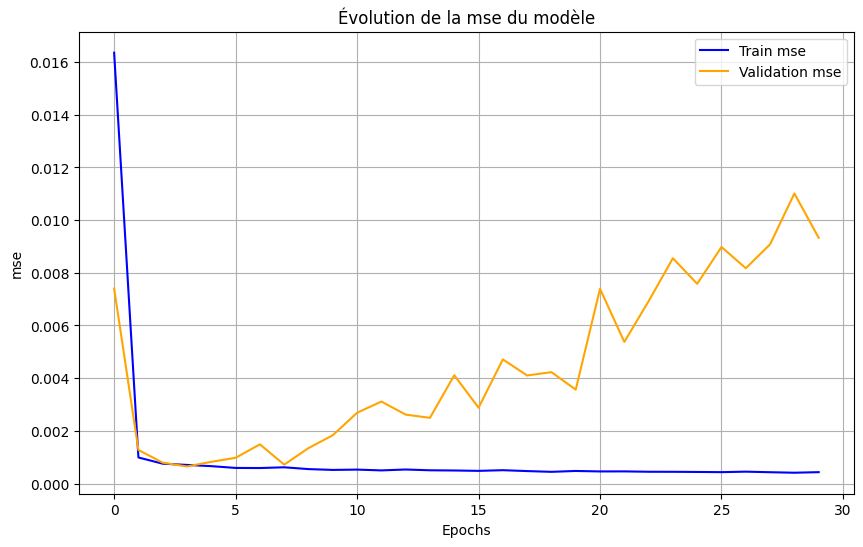

In [11]:
# Exemple de récupération des valeurs du mse du train et du val (validation)
train_mse = history.history['mse']
val_mse = history.history['val_mse']

# Créer un graphique
plt.figure(figsize=(10, 6))
plt.plot(train_mse, label='Train mse', color='blue')
plt.plot(val_mse, label='Validation mse', color='orange')
# plt.ylim((0,2))

# Ajouter des labels et un titre
plt.title('Évolution de la mse du modèle')
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


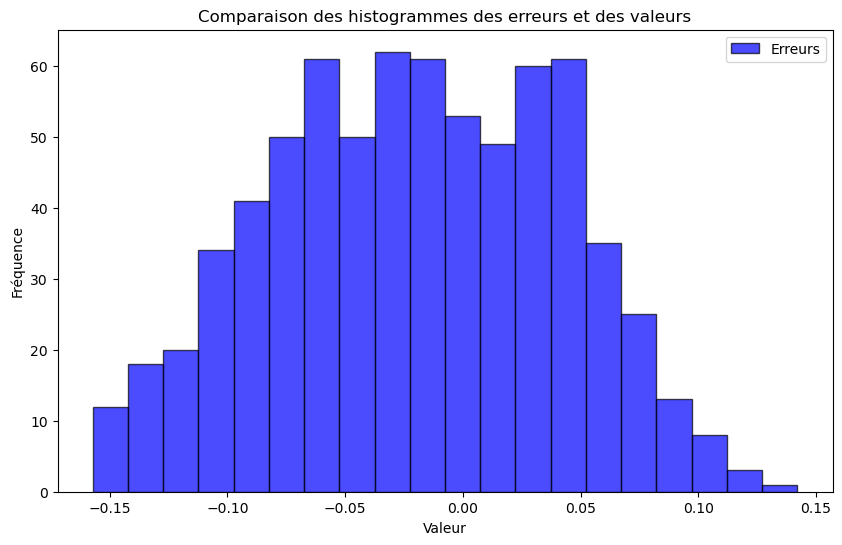

In [517]:
# Calculer les erreurs
y_pred = model.predict(X_test)
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
errors = y_test_flat - y_pred_flat  # y_test : valeurs réelles, y_pred : prédictions

plt.figure(figsize=(10,6))

# Histogramme des erreurs
plt.hist(errors, bins=20, color='blue', edgecolor="black", alpha=0.7, label='Erreurs')

# # Histogramme des valeurs réelles de test
# plt.hist(y_test, bins=20, edgecolor='blue', alpha=0.5, label='Valeurs réelles')

# # Histogramme des valeurs prédites
# plt.hist(y_pred, bins=20, edgecolor='green', alpha=0.5, label='Valeurs prédites')

plt.title('Comparaison des histogrammes des erreurs et des valeurs')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.hist(y_test.flatten(), bins=20, color="blue", edgecolor="black", alpha=0.7,)
plt.title("Y_test histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(2,1,2)
plt.hist(test_df.iloc[:,target_index], bins=20, color="blue", edgecolor="black", alpha=0.7,)
plt.title("Close price histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

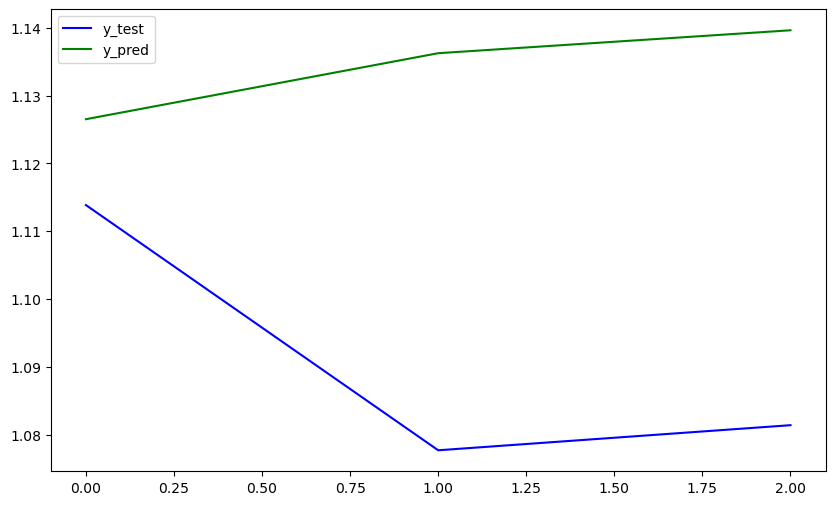

In [544]:
plt.figure(figsize=(10,6))
plt.plot(y_test[55], color="blue", label="y_test")
plt.plot(y_pred[55], color="green", label="y_pred")

plt.legend()

plt.show()

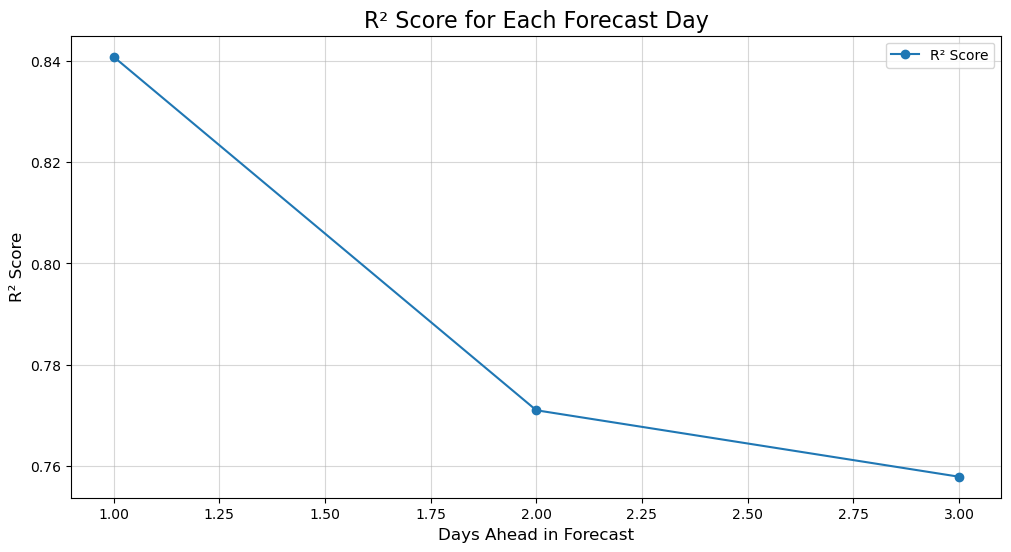

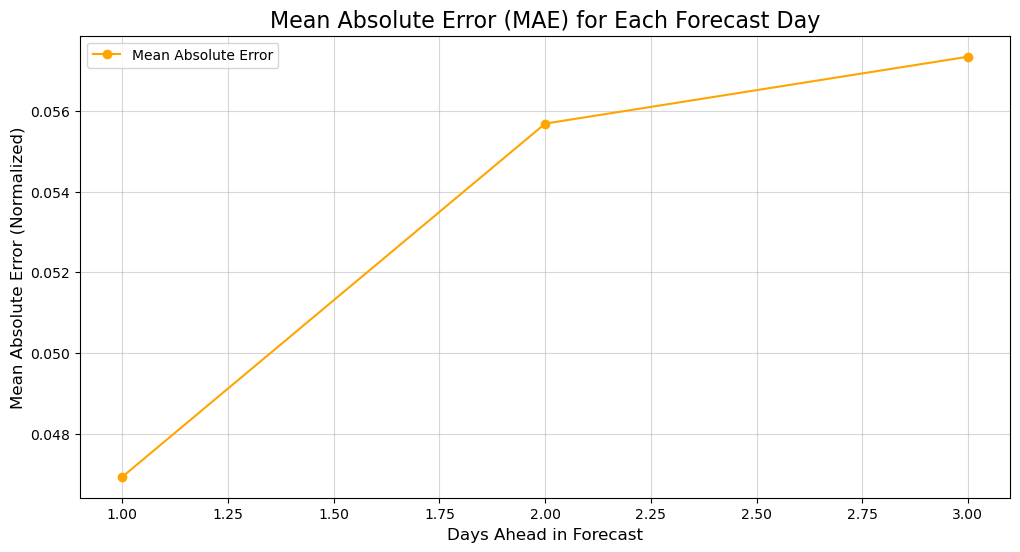

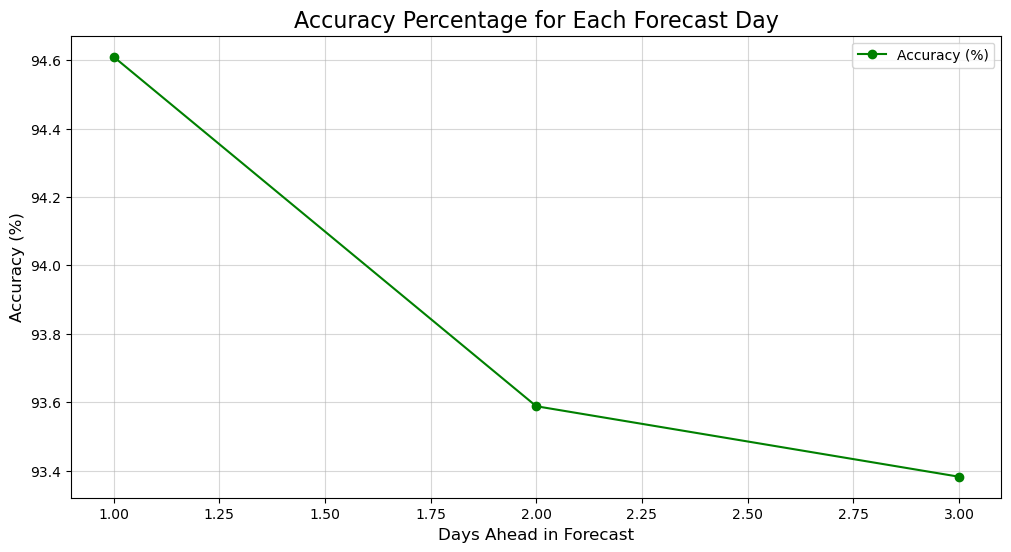

Day 1: Accuracy = 94.61%
Day 2: Accuracy = 93.59%
Day 3: Accuracy = 93.38%


In [545]:
# Initialize lists to store metrics
r2_scores = []
mae_scores = []
accuracy_percentages = []

# Loop through each forecast day
for day in range(y_test.shape[1]):  # Iterate over forecast horizon
    r2 = r2_score(y_test[:, day], y_pred[:, day])
    mae = mean_absolute_error(y_test[:, day], y_pred[:, day])
    mean_actual = np.mean(y_test[:, day])
    accuracy = 100 - (mae / mean_actual * 100)

    r2_scores.append(r2)
    mae_scores.append(mae)
    accuracy_percentages.append(accuracy)

# Plot R² Scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, y_test.shape[1] + 1), r2_scores, marker='o', label="R² Score")
plt.title("R² Score for Each Forecast Day", fontsize=16)
plt.xlabel("Days Ahead in Forecast", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Plot MAE Scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, y_test.shape[1] + 1), mae_scores, marker='o', color='orange', label="Mean Absolute Error")
plt.title("Mean Absolute Error (MAE) for Each Forecast Day", fontsize=16)
plt.xlabel("Days Ahead in Forecast", fontsize=12)
plt.ylabel("Mean Absolute Error (Normalized)", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Plot Accuracy Percentages
plt.figure(figsize=(12, 6))
plt.plot(range(1, y_test.shape[1] + 1), accuracy_percentages, marker='o', color='green', label="Accuracy (%)")
plt.title("Accuracy Percentage for Each Forecast Day", fontsize=16)
plt.xlabel("Days Ahead in Forecast", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Print accuracy percentages for reference
for day, acc in enumerate(accuracy_percentages, start=1):
    print(f"Day {day}: Accuracy = {acc:.2f}%")

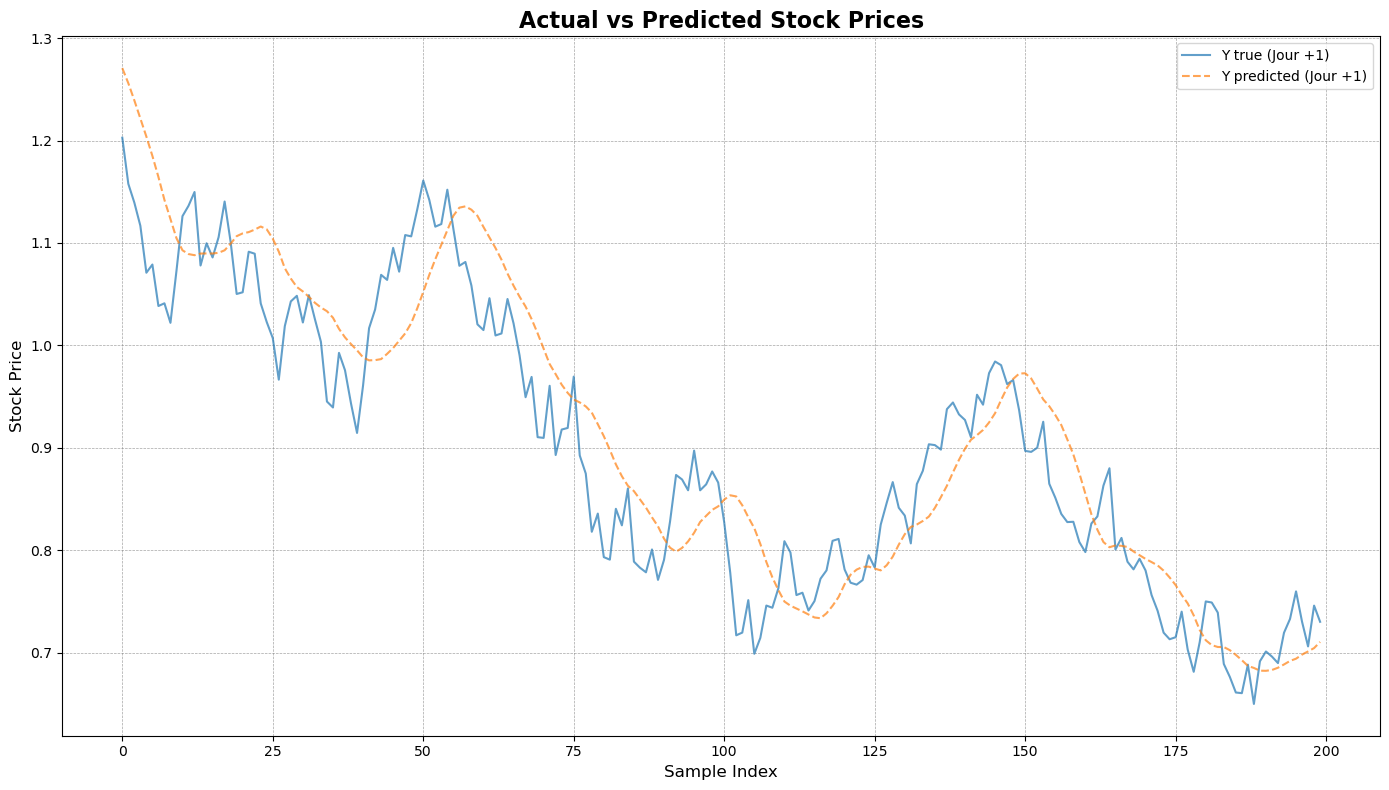

In [518]:
def plot_predictions(y_test, y_pred, window_size=100):
    """
    Affiche les vraies valeurs et les prédictions des prix d'actions en respectant la temporalité.
    
    Paramètres :
    - y_test : np.array de forme (N, 3), valeurs réelles
    - y_pred : np.array de forme (N, 3), valeurs prédites
    - window_size : int, nombre d'échantillons à afficher
    """
    plt.figure(figsize=(14, 8))

    # Vérification pour éviter d'afficher plus que la taille des données
    max_samples = min(len(y_test), window_size)

    # Tracer les vraies valeurs pour chaque jour de prévision
    plt.plot(range(max_samples), y_test[:max_samples, 0], label="Y true (Jour +1)", alpha=0.7, linewidth=1.5)
    #plt.plot(range(max_samples), y_test[:max_samples, 1], label="Y true (Jour +2)", alpha=0.7, linewidth=1.5)
    #plt.plot(range(max_samples), y_test[:max_samples, 2], label="Y true (Jour +3)", alpha=0.7, linewidth=1.5)

    # Tracer les prédictions en respectant le décalage temporel
    plt.plot(range(max_samples), y_pred[:max_samples, 0], '--', label="Y predicted (Jour +1)", alpha=0.7, linewidth=1.5)
    #plt.plot(range(1, max_samples), y_pred[:max_samples-1, 1], '--', label="Y predicted (Jour +2)", alpha=0.7, linewidth=1.5)
    #plt.plot(range(max_samples), y_pred[:max_samples, 2], '--', label="Y predicted (Jour +3)", alpha=0.7, linewidth=1.5)

    # Ajout des détails
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Actual vs Predicted Stock Prices", fontsize=16, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Stock Price", fontsize=12)
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()

    # Affichage
    plt.show()

# Exemple d'utilisation avec une fenêtre de 500 échantillons
plot_predictions(y_test, y_pred, window_size=200)

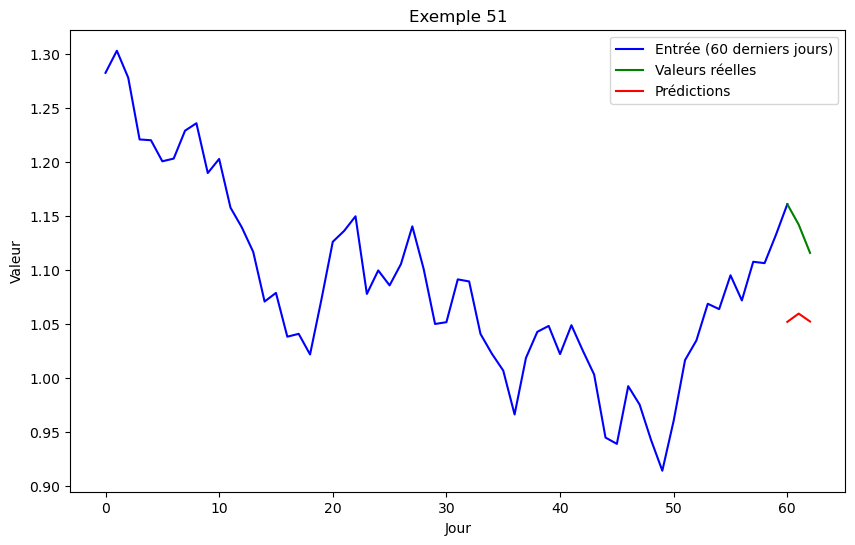

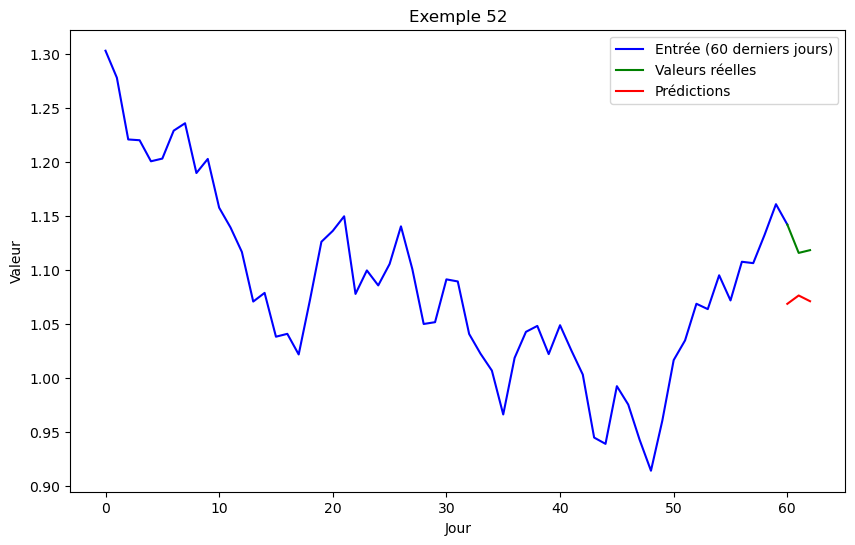

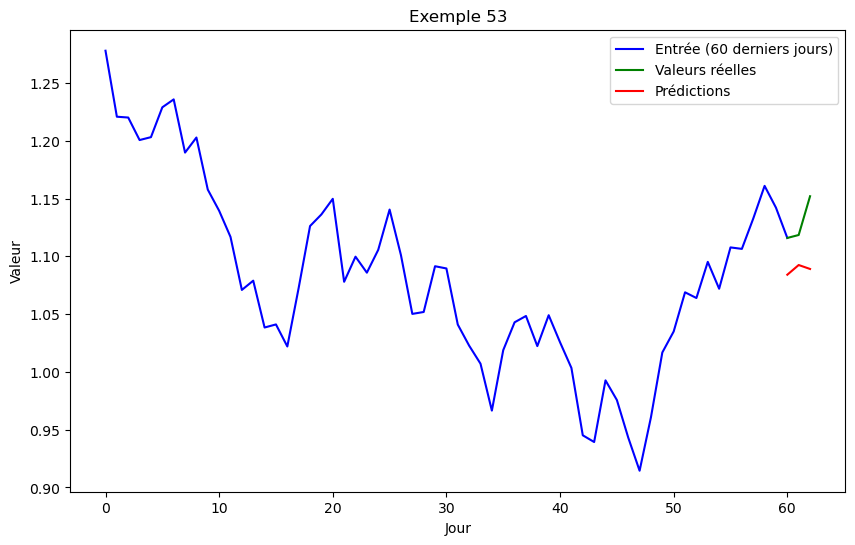

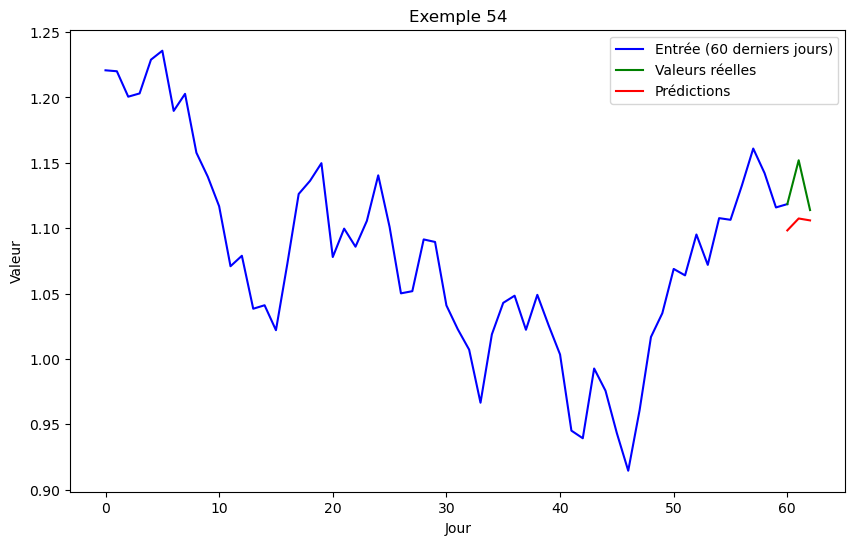

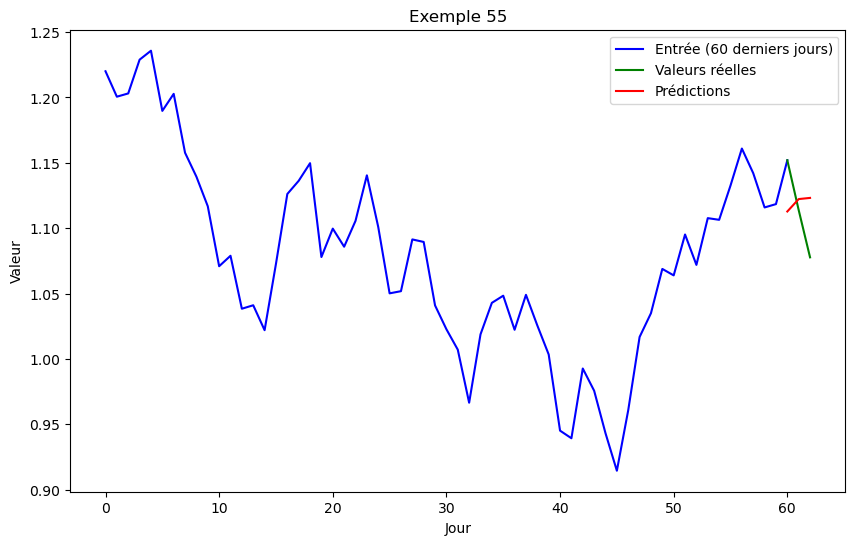

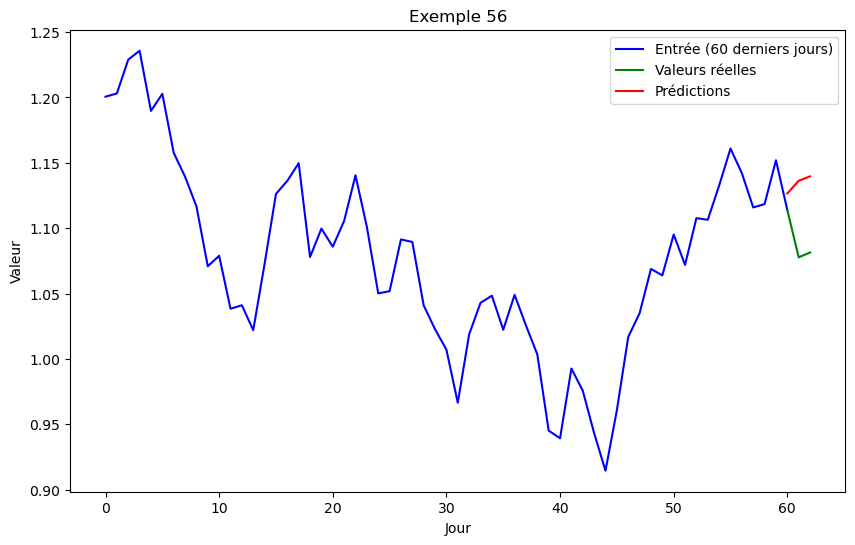

In [519]:
import matplotlib.pyplot as plt

for i in range(50,56):  # Afficher 5 exemples
    plt.figure(figsize=(10, 6))

    # Séquence d'entrée (les 60 derniers jours)
    plt.plot(range(sequence_length + 1), test_df_scaled[i:61+i, target_index], label="Entrée (60 derniers jours)", color='blue')

    # Valeurs réelles pour les 3 prochains jours
    plt.plot(range(sequence_length, sequence_length + prediction_steps), y_test[i], label="Valeurs réelles", color='green')

    # Prédictions pour les 3 prochains jours
    plt.plot(range(sequence_length, sequence_length + prediction_steps), y_pred[i], label="Prédictions", color='red')

    plt.legend()
    plt.title(f"Exemple {i+1}")
    plt.xlabel("Jour")
    plt.ylabel("Valeur")
    plt.show()


# Model Welto

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from linformer import Linformer


# Define the TCN block
def TCN_Block(input_shape, num_filters=64, kernel_size=3, dilation_rates=[1, 2, 4, 8], dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for rate in dilation_rates:
        x = layers.Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=rate,
            padding='causal',
            activation='relu',
            kernel_regularizer=regularizers.l2(1e-4)  # L2 Regularization
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    return tf.keras.Model(inputs, x, name="TCN_Block")


# Define the optimized Transformer block using MultiHeadAttention
def Optimized_Transformer_Block(input_shape, num_heads=4, ff_dim=64, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)

    # Multi-head attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization()(attention_output + inputs)  # Residual connection

    # Feed-forward layer
    ff_output = layers.Dense(ff_dim, activation='relu')(attention_output)
    ff_output = layers.Dropout(dropout_rate)(ff_output)
    ff_output = layers.Dense(input_shape[-1])(ff_output)
    ff_output = layers.LayerNormalization()(ff_output + attention_output)  # Residual connection

    return tf.keras.Model(inputs, ff_output, name="Optimized_Transformer_Block")


def TCN_Transformer_Model(input_shape, tcn_filters=64, transformer_heads=4, transformer_ff_dim=64, dropout_rate=0.2,
                          forecast_horizon=5):
    inputs = tf.keras.Input(shape=input_shape)

    # TCN Block
    tcn = TCN_Block(input_shape, num_filters=tcn_filters, dropout_rate=dropout_rate)(inputs)

    # Transformer Block
    transformer = Optimized_Transformer_Block(input_shape=(tcn.shape[1], tcn.shape[2]),
                                              num_heads=transformer_heads,
                                              ff_dim=transformer_ff_dim,
                                              dropout_rate=dropout_rate)(tcn)

    # Dense Layers for prediction
    x = layers.GlobalAveragePooling1D()(transformer)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(forecast_horizon, activation='linear')(x)  # Predict a vector of length forecast_horizon

    return tf.keras.Model(inputs, outputs, name="TCN_Transformer_Model")

In [109]:
# Define the input shape
input_shape = (60, X_train.shape[2])  # 60 time steps, features excluding 'Close'

model = TCN_Transformer_Model(
    input_shape=input_shape,
    tcn_filters=64,
    transformer_heads=4,
    transformer_ff_dim=64,
    dropout_rate=0.2,
    forecast_horizon=3
)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

Model: "TCN_Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TCN_Block (Functional)          │ (None, 60, 64)         │        39,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Optimized_Transformer_Block     │ (None, 60, 64)         │        74,944 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,403 (462.51 KB)

 Trainable params: 117,891 (460.51 KB)

 Non-trainable params: 512 (2.00 KB)

In [110]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1800 - mae: 0.2932 - val_loss: 0.1343 - val_mae: 0.3050 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0488 - mae: 0.1186 - val_loss: 0.1309 - val_mae: 0.3006 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0459 - mae: 0.1124 - val_loss: 0.0672 - val_mae: 0.1702 - learning_rate: 0.0010
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0432 - mae: 0.1053 - val_loss: 0.0492 - val_mae: 0.1447 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0404 - mae: 0.0989 - val_loss: 0.0596 - val_mae: 0.1749 - learning_rate: 0.0010
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0387 - mae: 0.0961 - val_loss: 0.0433 - val_mae: 0.1085 - learning_rate: 0.0010
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0384 - mae: 0.0962 - val_loss: 0.0483 - val_mae: 0.1332 - learning_rate: 0.0010
Epoch 8/50
29

In [111]:
# Prédiction
y_pred = model.predict(X_test)
test_loss, test_mae = model.evaluate(X_test, y_test)

# Calcul des métriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
nmae = mae / np.mean(np.abs(y_test))
accuracy = 100 - (100 * (test_loss / y_test.mean()))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Affichage des résultats dans une seule fenêtre
print(f'----- Résultats des métriques -----')
print(f'RMSE : {rmse}')
print(f'MAE : {mae}')
print(f'R² : {r2}')
print(f'NMAE : {nmae}')
print(f"Model Accuracy: {accuracy:.2f}%")
print(f"MAPE: {mape:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - mae: 0.0793 
----- Résultats des métriques -----
RMSE : 0.10625458811685762
MAE : 0.08553331036735166
R² : -0.45546521887257935
NMAE : 0.15771603065060033
Model Accuracy: 94.80%
MAPE: 17.68%


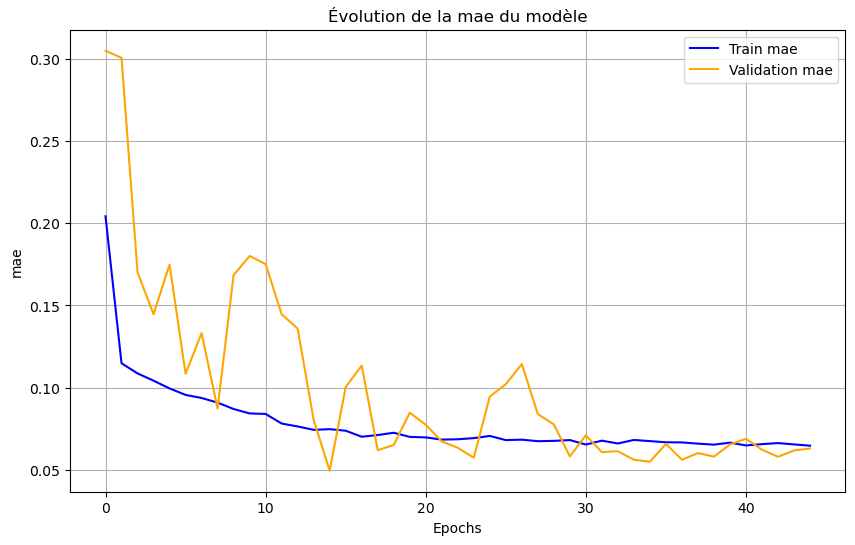

In [112]:
# Exemple de récupération des valeurs du mse du train et du val (validation)
train_mse = history.history['mae']
val_mse = history.history['val_mae']

# Créer un graphique
plt.figure(figsize=(10, 6))
plt.plot(train_mse, label='Train mae', color='blue')
plt.plot(val_mse, label='Validation mae', color='orange')
# plt.ylim((0,2))

# Ajouter des labels et un titre
plt.title('Évolution de la mae du modèle')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

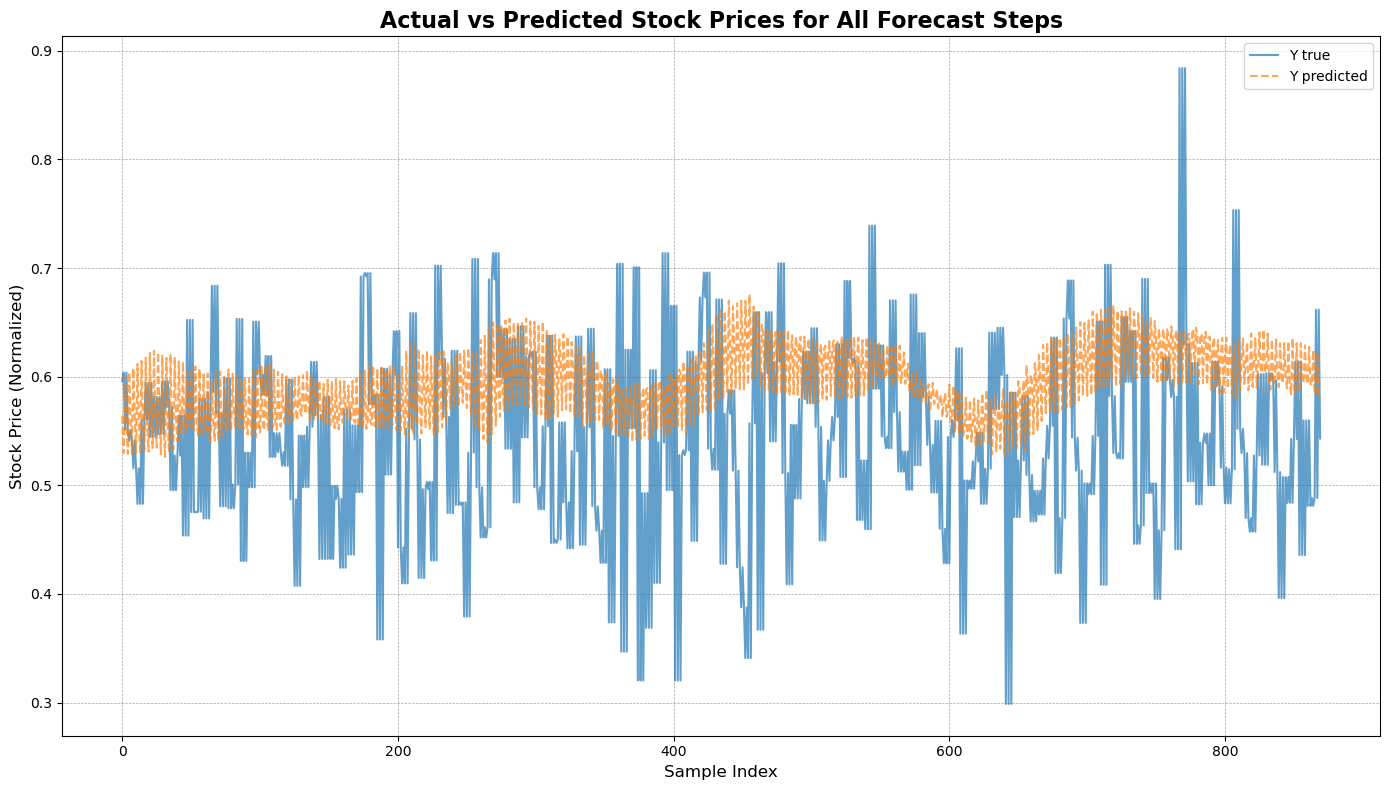

In [113]:
# Plot predictions and actuals for all forecast steps
plt.figure(figsize=(14, 8))

# Flatten y_test and y_pred
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

plt.plot(y_test_flat[:1000], label=f"Y true", alpha=0.7, linewidth=1.5)
plt.plot(y_pred_flat[:1000], label=f"Y predicted", linestyle='--', alpha=0.7, linewidth=1.5)

# Add gridlines and details
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Add title and axis labels
plt.title("Actual vs Predicted Stock Prices for All Forecast Steps", fontsize=16, fontweight='bold')
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Stock Price (Normalized)", fontsize=12)

# Add legend
plt.legend(loc="upper right", fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()
